[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


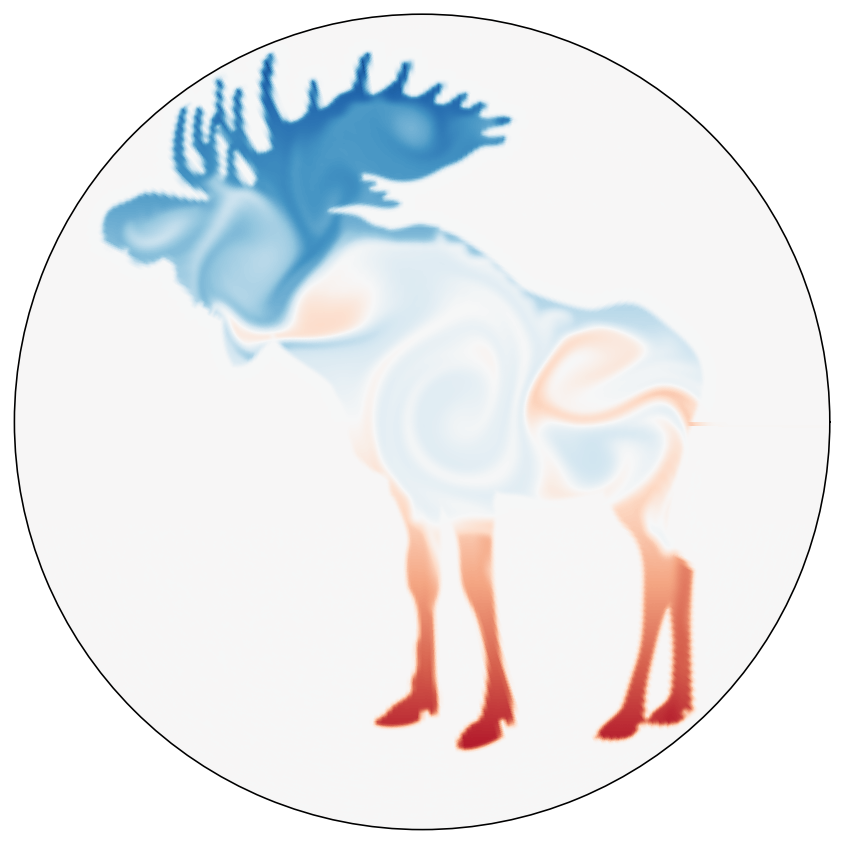

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import dedalus.public as d3
import h5py
from scipy.interpolate import RegularGridInterpolator as RGI

fig = plt.figure(figsize=(7.5, 7.5))
ax = fig.add_subplot(1,1,1, polar=True)

Ra = 1e8
Pr = 1
nu = np.sqrt(Pr/Ra)
Lx = 2
Nr = 128
Nphi = 2*Nr
nx = Nr*2

dtype = np.float64
dealias = 3/2
hires_factor = 10

coords = d3.PolarCoordinates('phi', 'r')
dist = d3.Distributor(coords, dtype=dtype)
basis = d3.DiskBasis(coords, shape=(Nphi, Nr), radius=1, dealias=dealias, dtype=dtype, azimuth_library='matrix')
phi, r = dist.local_grids(basis, scales=(hires_factor*dealias, hires_factor*dealias))
phi_de, r_de = dist.local_grids(basis, scales=(dealias, dealias))

T = dist.Field(name='T', bases=basis)
with h5py.File('dynamics_slices.h5', 'r') as f:
    T['g'] = f['tasks/T'][-1,:,:]
T.change_scales(hires_factor*dealias)

mask = dist.Field(name='mask', bases=basis)   
with h5py.File('../masks/moosinesq_Ra{:.1e}_{}x{}_de{:.1f}.h5'.format(Ra, Nr,Nphi,dealias)) as f:
    mask.change_scales(dealias)
    mask['g'] = f['mask'][()]
mask_interp = RGI((phi_de.ravel(), r_de.ravel()), mask['g'], bounds_error=False, fill_value=0)

rr, pp = np.meshgrid(r, phi)
print(mask_interp((pp, rr)))
ax.pcolormesh(pp, rr, T['g']*(1-mask_interp((pp, rr))), shading='auto', cmap='RdBu_r', vmin=-0.5, vmax=0.5)
#ax.pcolormesh(pp, rr, T['g'], shading='auto', cmap='RdBu_r', vmin=-0.5, vmax=0.5)
ax.set_rticks([])
ax.set_xticks([])


fig.savefig('paper_figure02.png', dpi=400, bbox_inches='tight')
#fig.savefig('paper_figure02.pdf', dpi=400, bbox_inches='tight')